# 量子アニーリングマシンによる Surface Code 復号問題の解法

このチュートリアルでは、量子情報処理における誤り訂正符号である Surface Code の復号問題を扱います。

$0$ か $1$ のいずれかの状態をとる古典コンピュータの「ビット」を、$\ket{0}$ と $\ket{1}$ の重ね合わせの状態をとる「量子ビット」に置き換えたゲート方式量子コンピュータは、素因数分解などの計算を高速に行うことができ、セキュリティ技術等に大きな影響を及ぼすとして注目されています。しかし、その実現にあたって量子ビットに発生するエラーの多さが課題となっています。

例えば、ある量子プログラムは、エラーのない理想的な環境で実行した場合、必ず $\ket{0}$ を出力するか、必ず $\ket{1}$ を出力する（何回実行しても、同じものを出力する）ものとします。ある人はこれが $\ket{0}$、$\ket{1}$ どちらなのか知りたいので、実際にプログラムを実行して確かめることにしました。

ここで、私たちは神様になったつもりで、正解は $\ket{0}$ である、つまり理想的な環境では必ず $\ket{0}$ が出力されることを知っているものとします。

ところが、エラーが起こる現実の環境でプログラムを実行した場合、ある確率 $p_0$ で $\ket{0}$ が出力され、確率 $1-p_0$ で $\ket{1}$ が出力されてしまいます。

この $p_0$ が十分高い場合は、何度かプログラムを実行して出力たちの多数決をとれば信頼性の高い結果が得られます。一方で、エラーというのは蓄積し、また演算によって量子ビット間で伝播するものなので、何も対策しなければプログラムの規模が大きくなるほど $p_0$ が 50 % に近づいてしまい、出力される計算結果が意味を持たないものになってしまいます。

大規模な量子計算を行うためには、計算の途中でこまめにエラーを訂正する必要があります。

そこで、複数の量子ビットで 1 つの論理ビットを表すことでエラーを訂正（復号）できるようにした量子誤り訂正符号が考えられています。これは古典情報処理におけるエラー訂正手法を応用したものですが、
- 量子ビットを複製することはできない（量子複製不可能定理）
- 量子ビットは観測することで変化してしまう

という問題があるため、量子ビットに適用するためには工夫が必要です。

そんな中で有力な符号化方式の 1 つが今回取り扱う Surface Code であり、発生したエラーは組合せ最適化問題を解くことで訂正することができます。

Surface Code を用いて計算の途中で定期的にエラー訂正を行うことで、理論上は $p_0$ を 100 % にいくらでも近づけることが可能になり、信頼できる計算結果を得ることができます。

それでは、量子アニーリングマシンを用いて、エラーが発生した Surface Code を復号する問題を解いてみましょう。Surface Code は配置の異なるいくつかの種類が提案されていますが、ここではその 1 つの Planar Surface Code を扱い、以下 Planar Surface Code のことを単に Surface Code と呼びます。基本原理はどれも同じなので、ここで紹介する解法は他の配置にも同様に適用することができます。

## Surface Code とは

Surface Code とは、データ量子ビットを格子状に並べたものを 1 つの論理ビットとし、間に「隣接するデータ量子ビットのエラー個数の偶奇」を反映する補助量子ビットを配置・測定することで、エラー状況を推定・訂正できるようにする符号化手法です ([E. Dennis, A. Kitaev, A. Landahl, and J. Preskill, "Topological quantum memory," J. Math. Phys., vol. 43 (9), 4452–4505, 2002.
‌](https://pubs.aip.org/aip/jmp/article-abstract/43/9/4452/230976/Topological-quantum-memory)) 。

ここでは、格子サイズを $d=7$ とします。このとき、データ量子ビット格子の形状は以下の図のようになります。

![](../figures/surface_code_decoder/qubit_lattice.png)

格子状に並べられた 〇 がデータ量子ビットを表しています。便宜上、現在すべてのデータ量子ビットが $\ket{0}$ になっているとします。

この格子が 1 つの論理ビットを表すということは、格子全体として 2 つの状態 $\ket{0}_L$ と $\ket{1}_L$ の重ね合わせ状態になっていてほしいです。ここで、下付き添え字の $L$ は論理ビット（Logical qubit）であることを表します。一方で、1 つ 1 つのデータ量子ビットが 2 つの状態の重ね合わせ状態にあり、格子サイズ $d=7$ の場合 $85$ 個のデータ量子ビットからなるため、格子全体は $2^{85}$ 個の状態の重ね合わせになっています。

そのため、これらの状態を 2 つに分類し、一方を $\ket{0}_L、$もう一方を $\ket{1}_L$ と見なします。

厳密には、後述する補助量子ビットによって「エラーが検知されている状態」は論理ビットとして有効な状態とは見なしません。有効な状態は格子サイズ $d=7$ の場合 $2^{43}$ 個存在し、そのうち半分を $\ket{0}_L、$もう半分を $\ket{1}_L$ と見なします。

Surface Code では、下図のように一番上の行にあるデータ量子ビットの中の $\ket{1}$ を数え、偶数個なら $\ket{0}_L、$奇数個なら $\ket{1}_L$ とします。現在は $\ket{1}$ は 0 個ですので、この状態は $\ket{0}_L$ です。

![](../figures/surface_code_decoder/logical_qubit_value.png)

一番上の行だけで格子全体の状態が決まるのだから、それ以外の行のデータ量子ビットはなくてもいいように感じるかもしれませんが、このように二次元に冗長化することでエラーの訂正が可能になります。

いくつかのデータ量子ビットにエラーが発生したときの様子を見ていきましょう。ここでのエラーとは、$\ket{0}$ が $\ket{1}$ になってしまうようなビットの反転を指します。

![](../figures/surface_code_decoder/qubit_lattice_error.png)

エラーが発生し、$\ket{0}$ から $\ket{1}$ に変わったデータ量子ビットを**赤色**で表しています。

#### エラーの訂正方法

「エラーとはビット反転を指す」としましたが、実際の量子ビットには、そのような離散的なエラーではないアナログのエラーが想定されます。しかし、後述する補助量子ビットを用いた観測によって、アナログのエラーは「01 反転」と「位相反転」の 2 種類のエラーに離散化され、これらは同様の手法で独立に訂正することが可能です。

そのため、ここでは「01 反転」のエラーのみ発生すると仮定して説明します。

エラー位置を特定し、意図的にもう一度反転させることができればエラーを訂正することができます。

そこで、「隣接するデータ量子ビットのエラー個数の偶奇」を反映する補助量子ビットを間に配置し、古典情報処理のパリティチェックの要領でエラー位置を推定します。

![](../figures/surface_code_decoder/surface_code.png)

先ほどの格子に、 ☐ で表された補助量子ビットが追加されました。
補助量子ビットは、隣接するデータ量子ビットのエラー個数が偶数のものを**白色**、奇数のものを**黒色**で示しています。

ここで、エラーが発生しているデータ量子ビットに沿って赤色の線を表示していますが、黒色の補助量子ビットはこの赤色の線の両端に現れるという性質があるため、データ量子ビット・補助量子ビットの状況の対応が分かりやすいよう補助線として表示しています。

補助量子ビットを用いて「隣接するデータ量子ビットのエラー個数の偶奇」を観測することで、データ量子ビット格子の状態について部分的に情報を得ることができます。

ここまで、説明のためにデータ量子ビットのエラー状況が見えている図を示しましたが、実際には観測することはできません。以下に、データ量子ビットのエラー状況を隠した図を示します。

![](../figures/surface_code_decoder/stabilizers.png)

Surface Code の復号は、与えられた補助量子ビットの測定結果から、データ量子ビットのエラー状況、すなわち先程の図の **赤色の 〇** の位置として最も可能性が高いものを推定し、データ量子ビットを意図的に反転させて元に戻すことで行われます。

復号の例を示します。例えば、以下のようにエラーを推定、訂正したとします。

![](../figures/surface_code_decoder/solution_success.png)　　　![](../figures/surface_code_decoder/correction_success.png)

左図では、実際のエラー状況に対して、推定エラー位置を**緑色**の枠線で表しています。右図は推定エラー位置を反転させたものを示しています。

ここで注意しなければいけないのは、「実際にはエラーが発生していないデータ量子ビット」をエラーありと誤って推定した場合、エラーを直そうとして反転させているつもりが、実際には逆にエラーを生み出してしまっていることです。この例では、推定エラー位置は補助量子ビットの測定結果に対応しているものの、（特に格子の上半分において）実際のエラー状況と大きく異なっているため、訂正操作によってエラーはむしろ増えてしまいました。

ひどい失敗例…と思ったかもしれませんが、実はこれは復号成功です。なぜなら、論理ビットの状態は一番上の行にあるデータ量子ビットの中の $\ket{1}$ の個数（ここではエラー個数と同じ）の偶奇によって決まるからです。一番上の行にあるデータ量子ビットの中の $\ket{1}$ の個数は、エラー発生前は 0 個（偶数） 、現在は 2 個（偶数）であり、これらの状態はどちらも $\ket{0}_L$ を表します。

エラーが残っているデータ量子ビットに沿って赤色の線を表示していますが、格子の一番上の行から一番上の行へ繋がるパス、格子の一番下の行から一番下の行へ繋がるパス、格子内で閉じている閉路状のエラーは、これらの有無が論理ビットの状態に影響を与えないため、 trivial loop と呼ばれます。この trivial loop はエラー訂正の成功を妨げるものではありません。

推定エラー位置の反転後に以下の 2 つの条件がともに満たされているとき、エラー訂正は成功となります。

- 隣接するデータ量子ビットのエラー個数が奇数である補助量子ビットがない
- 一番上の行のデータ量子ビットに残ったエラー個数が偶数

では、1 つ目の条件を満たすが 2 つ目の条件を満たさない場合とは、どのようなものでしょうか。

以下に示すエラー訂正失敗の例を見て確認しましょう。

![](../figures/surface_code_decoder/solution_failure.png)　　　![](../figures/surface_code_decoder/correction_failure.png)

左図が実際のエラー状況と推定エラー位置、右図が推定エラー位置を反転させたものを示しています。

右図を見ると、一番上の行から蛇行しながら一番下の行まで繋がるパス状にエラーが残っていることが確認できます。このようなエラーは論理ビットの状態（一番上の行にあるデータ量子ビットの中の $\ket{1}$ の個数の偶奇）を反転させますが、補助量子ビットでは検知することができないため、エラーの訂正が不可能となります。

論理ビットの反転を引き起こす検知不可能なエラーはこのような格子の一番上の行から一番下の行へ繋がるパスに限られ、少なくとも $d$ (格子サイズ) 個のエラーが連なったものになります。
格子サイズ $d$ を大きくするほどこのような状態になる可能性は小さくなるため、量子プログラムの規模に応じて十分大きな $d$ をとる必要があります。

実際に量子プログラムを実行する際には、計算の途中に上記の「補助量子ビットを用いた観測とデータ量子ビットへの操作によるエラー訂正」を定期的に行います。最後に出力を得るときは、各データ量子ビットを直接観測し、 $\ket{0}_L$ か $\ket{1}_L$ かを確認します。

## Surface Code 復号問題の定式化

Surface Code 復号問題について、以下の文献でQUBO定式化が行われています。

[J. Fujisaki, H. Oshima, S. Sato, and K. Fujii, "Practical and scalable decoder for topological quantum error correction with an Ising machine," Phys. Rev. Res., vol. 4 (4), 043086, 2022.
](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.043086)

この文献の方法を参考にした上で、復号問題における制約条件の定式化方法を改良したものを説明します。

ここでは、各データ量子ビットについて独立に、一定の確率 $p$ でエラーが発生するような問題設定を考えます。

また、実際には補助量子ビットでの測定にもエラーが発生し、「隣接するデータ量子ビットのエラー個数の偶奇」と逆の測定結果を得てしまうことがありますが、ここでは問題を簡単にするため測定エラーは発生しないものとします。

Surface Code 復号問題は、**与えられた補助量子ビットの測定結果に合致するようなデータ量子ビットのエラー状況のうち、最も起こりうる確率が高いものを求める**組合せ最適化問題です。

エラー発生確率 $p$ は小さいので、エラー発生箇所の多い状況が起こる確率は低くなります。

つまり、以下のような制約条件下において目的関数を最小化するデータ量子ビットのエラー状況を求めればよいです。

- 目的関数： データ量子ビットのエラー個数
- 制約条件： 各補助量子ビットについて、隣接するデータ量子ビットのエラー個数の偶奇は測定結果と等しい

### 最適化問題の入力および決定変数の定義

各補助量子ビット $j$ における「隣接するデータ量子ビットのエラー個数の偶奇」の測定結果を $\{m_j\}$ とします。

- 補助量子ビット $j$ に隣接するデータ量子ビットのエラー個数は偶数：$m_j=0$
- 補助量子ビット $j$ に隣接するデータ量子ビットのエラー個数は奇数：$m_j=1$

各データ量子ビット $i$ にエラーが発生しているかどうかをバイナリ変数 $\{x_i\}$ で表します。

- データ量子ビット $i$ にエラーが発生していない：$x_i=0$
- データ量子ビット $i$ にエラーが発生している： $x_i=1$

![](../figures/surface_code_decoder/input_and_variable.png)

$\{m_j\}$ は入力で与えられる定数、$\{x_i\}$ は最適化問題の決定変数であることに注意してください。

### 目的関数の定式化

目的関数は「データ量子ビットのエラー個数」なので、
$$
  \sum_i x_i
$$
と表すことができます。

### 制約条件の定式化

補助量子ビット $j$ について、隣接するデータ量子ビットのエラー個数を $S_j$ とします。すなわち、補助量子ビット $j$ に隣接するデータ量子ビットの集合を $\delta j$ として、

$$
  S_j = \sum_{i\ \in\ \delta j} x_i
$$

とします。制約条件は「隣接するデータ量子ビットのエラー個数の偶奇は測定結果と等しい」なので、

$$
  S_j\!\!\!\mod{2}~=~m_j
$$
と表せます。

1 つの補助量子ビットに隣接するデータ量子ビットは最大 4 つであることから、$0 \le S_j \le 4$ が成り立ちます。

さらによく観察すると、最適解の 1 つとしてどの補助量子ビット $j$ についても $0 \le S_j \le \bold{3}$ を満たすものが必ず存在することがいえます。

（詳細な説明はチュートリアルの最後にある「[〈補足〉「どの補助量子ビット $j$ についても $S_j \le \bold{3}$ を満たす最適解が必ず存在する」ことの説明](#proof)」に記載しています。）

すべての補助量子ビット $j$ について $0 \le S_j \le \bold{3}$ を満たすようなエラー状況しか考慮しないことにすると、上式は「$S_j$ から $0, 2$ のいずれかを引くと $m_j$ になる」と言い換えられます。
そこで、補助バイナリ変数 $z_j$ を用意すると、制約条件は

$$
  S_j-2z_j-m_j=0
$$

と表せます。

以上で、目的関数・制約条件をバイナリ変数列 $\{x_i\}, \{z_j\}$ を用いて表すことができました。

#### Note

Fujisaki らによる定式化では、制約条件「$S_j\!\!\mod{2} = m_j$」を「$(-1)^{S_j~+~m_j} = 1$」と言い換え、

$$
  (1-2m_j)\prod_{i\ \in\ \delta j}(1-2x_i) ~= 1
$$

と表しています。1 つの補助量子ビットに隣接するデータ量子ビットは最大 4 つであることから、左辺は最大で 4 次式になります（$m_j$ は定数であることに注意）。Amplify SDK では、利用するソルバーに合わせた適切な次数への変形を自動で行うため、このような高次式を扱うことができますが、前述の方法に比べて補助変数の数が増えるため、性能低下につながる可能性があります。

## Surface Code 復号問題の求解

上記の定式化をもとに、Amplify SDK を用いて Surface Code 復号問題の解法を実装しましょう。

### データ量子ビット・補助量子ビットの添え字の割り当て

データ量子ビットは二次元の添え字で管理します。横に並んだデータ量子ビットたちを 1 行とみなし、上から $0,1,2,\dots$ 行目、行の中で左から $0,1,2,\dots$ 列目とします。
補助量子ビットも同様に、上から $0,1,2,\dots$ 行目、行の中で左から $0,1,2,\dots$ 列目とします。
データ量子ビットの場合、$1,3,5,\dots$ 行目は 1 列少ないことに注意してください。
格子サイズ $d=5$ の場合の例を以下に示します。

![](../figures/surface_code_decoder/qubits_index.png)　　　![](../figures/surface_code_decoder/stabilizers_index.png)

補助量子ビット $(i, j)$ に対して、上、左、右、下に隣接するデータ量子ビットの添え字はそれぞれ $(2i, j)$、$(2i + 1, j - 1)$、$(2i + 1, j)$、$(2i + 2, j)$ となります。

$(i, j)=(2, 1)$ の例を以下に示します。

![](../figures/surface_code_decoder/surface_code_index.png)


### 問題の生成

今回扱う問題として、ランダムにエラーを発生させたデータ量子ビット格子を生成します。

格子サイズを $d=11$、各データ量子ビットのエラー率を $p=8$ %とします。

データ量子ビットの情報は qubits という名前の配列に格納され、エラーが発生している場合は 1、そうでない場合は 0 になっています。

次に、生成したデータ量子ビットのエラー情報をもとに、補助量子ビットでの「隣接するデータ量子ビットのエラー個数の偶奇」の測定結果を生成し、stabilizers という名前の配列に格納します。

stabilizers という配列名は、「Surface Code は stabilizer code と呼ばれる符号化手法の一種であり、『隣接するデータ量子ビットのエラー個数の偶奇』は stabilizer code における『stabilizer の固有値』に対応している」ことに由来しています。

#### Note

格子サイズ $d$ は偶数でも問題なく動作しますが、奇数であることが一般的です。エラー訂正の原理は多数決がベースになっており、$d$ 個のデータ量子ビットのうち半数以上にエラーが発生しなければ訂正できます。このことから、$d=2k$ の場合と $d=2k-1$ の場合では、許容できるエラー個数がともに最大 $k-1$ 個と差がなく、偶数にするのは損であるため、$d$ は奇数にするのが一般的です。

エラー率 $p$ は大きいほうが難しい問題となり、理論的には $p=10$ % 程度まで復号可能ですが、今回は短い計算時間で十分高い確率で復号できるよう、そこから少し下げて $p=8$ % としました。

In [21]:
import numpy as np

# 確率 p でエラーを発生させたサイズ d のデータ量子ビット格子を生成
# 確率 p で 1（エラーあり）、確率 1-p で 0（エラーなし）が格納される
def generate_qubit_lattice(
    d: int,
    p: float,
    seed: int | None
) -> np.ndarray:
    rng = np.random.default_rng(seed)
    qubits = np.where(rng.random((d * 2 - 1, d)) < p, 1, 0)
    qubits[1::2, -1] = (
        0  # 1,3,5,... 行目はデータ量子ビットが 1 つ少ないので、右端を 0 で埋める
    )
    return qubits


# データ量子ビットのエラー情報から補助量子ビットでの測定結果をシミュレート
def measure_stabilizers(qubits: np.ndarray) -> np.ndarray:
    d = len(qubits[0])
    stabilizers = np.zeros((d - 1, d), dtype=int)
    for i in range(d - 1):
        for j in range(d):
            stabilizers[i, j] = (
                qubits[i * 2, j]
                ^ qubits[i * 2 + 1, j - 1]
                ^ qubits[i * 2 + 1, j]
                ^ qubits[i * 2 + 2, j]
            )
    return stabilizers

d = 11  # 格子サイズ
p = 0.08  # データ量子ビットのエラー率
qubits = generate_qubit_lattice(d, p, 0)  # 確率 p でエラーを発生させたサイズ d のデータ量子ビット格子
stabilizers = measure_stabilizers(qubits)  # 補助量子ビットでの測定結果

量子ビット格子を可視化する関数を定義します。

In [22]:
import cv2
from IPython.display import display, Image


# 量子ビット格子の様子を図示
def show_sc_img(
    qubits: np.ndarray,  # データ量子ビットのエラー情報
    modified: np.ndarray | None,  # 修正したデータ量子ビットの情報
    stabilizers: np.ndarray,  # 補助量子ビットの情報
    radius: int = 10,
    thickness: int = 2,
) -> None:
    d = len(qubits[0])
    size = 6 * radius * d
    img = np.full((size, size, 3), 255, dtype=np.uint8)

    # データ量子ビット（丸、辺）を描く
    for i in range(d * 2 - 1):
        for j in range(d - i % 2):
            center = ((i % 2 + j * 2 + 1) * 3 * radius, (i + 1) * 3 * radius)

            # データ量子ビットが反転している場合、丸と辺を赤で塗りつぶす
            if qubits[i, j]:
                # 辺の伸び方（0, 2, ... 行目は縦、1, 3, ... 行目は横）
                dx = 3 * radius if i % 2 == 1 else 0
                dy = 3 * radius if i % 2 == 0 else 0
                cv2.line(
                    img=img,
                    pt1=(center[0] - dx, center[1] - dy),
                    pt2=(center[0] + dx, center[1] + dy),
                    color=(0, 0, 255),
                    thickness=thickness * 2,
                )
                cv2.circle(
                    img,
                    center=center,
                    radius=radius,
                    color=(0, 0, 255),
                    thickness=-1,
                )

            # 修正された箇所は緑色、そうでなければ黒色で丸の輪郭を描く
            outline_color = (
                (0, 255, 0) if modified is not None and modified[i, j] else (0, 0, 0)
            )
            cv2.circle(
                img=img,
                center=center,
                radius=radius,
                color=outline_color,
                thickness=thickness,
            )

    # 補助量子ビット（四角）を描く
    for i in range(d - 1):
        for j in range(d):
            pt1 = ((j * 6 + 2) * radius, (i * 6 + 5) * radius)
            pt2 = ((j * 6 + 4) * radius, (i * 6 + 7) * radius)

            # 補助量子ビットまわりで反転している量子ビットの数が奇数の場合、黒で塗りつぶす
            if stabilizers[i, j]:
                cv2.rectangle(img, pt1=pt1, pt2=pt2, color=(0, 0, 0), thickness=-1)

            # 黒色で四角の輪郭を描く
            cv2.rectangle(
                img=img, pt1=pt1, pt2=pt2, color=(0, 0, 0), thickness=thickness
            )

    # 描画したものを表示
    img = cv2.resize(img, (512, 512))
    _, buf = cv2.imencode(".png", img)
    display(Image(data=buf.tobytes()))

先ほど生成した量子ビット格子を可視化してみます。

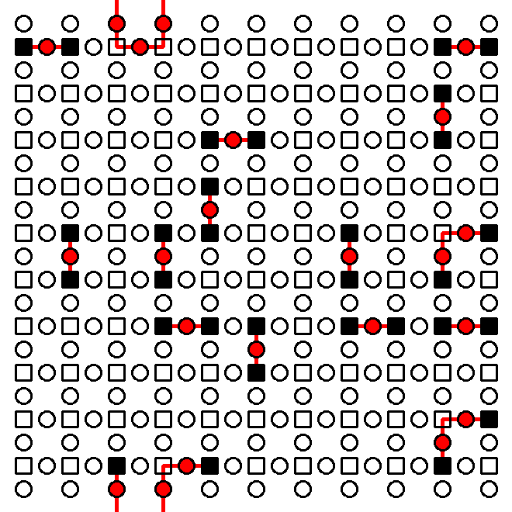

In [13]:
show_sc_img(qubits, None, stabilizers)

### 組合せ最適化モデルの構築

Amplify を用いて組合せ最適化モデルを構築します。

目的関数:

$$
  \sum_i x_i
$$


制約条件:

すべての補助量子ビット $j$ について、
$$
  S_j-2z_j-m_j=0
$$

目的関数は変数の和なので `sum` メソッドで、制約条件は ```equal_to``` 関数を用いて表現できます。

制約条件はすべての補助量子ビット $j$ について成り立っている必要がありますが、各 $j$ について立式し、```sum``` 関数を用いることで表現できます。

In [14]:
from amplify import VariableGenerator, equal_to, PolyArray, Model
from amplify import sum as amplify_sum

# 補助量子ビットの測定結果から組み合わせ最適化モデルを構築
def construct_model(d: int, stabilizers: np.ndarray) -> tuple[PolyArray, Model]:
    m = stabilizers  # 補助量子ビットでの測定結果

    gen = VariableGenerator()

    # データ量子ビットのエラー有無を表すバイナリ変数
    x = gen.array("Binary", d * 2 - 1, d)
    # 1,3,5,... 行目はデータ量子ビットが 1 つ少ないので、右端を定数 0 で埋める
    x[1::2, -1] = 0

    # 補助バイナリ変数
    z = gen.array("Binary", d - 1, d)

    # sum メソッドで目的関数を構築
    objective = x.sum()

    # 隣接するデータ量子ビットのエラー個数
    S = [
        [
            x[i * 2, j] + x[i * 2 + 1, j - 1] + x[i * 2 + 1, j] + x[i * 2 + 2, j]
            for j in range(d)
        ]
        for i in range(d - 1)
    ]

    # 制約条件の左辺
    left_values = [
        S[i][j] - 2 * z[i, j] - m[i, j]
        for i in range(d - 1)
        for j in range(d)
    ]

    # equal_to 関数と sum 関数で制約条件を構築
    constraints = amplify_sum([equal_to(left_value, 0) for left_value in left_values])

    # 目的関数と制約条件からモデルを構築
    model = Model(objective, constraints)

    return (x, model)

x, model = construct_model(d, stabilizers)

### 最適化の実行

Fixstars Amplify AE のクライアントを作成してパラメータの設定を行い、```solve``` 関数で問題を解きます。

In [15]:
from amplify import FixstarsClient, solve, Result
from datetime import timedelta

def solve_optimization(model: Model, timeout_ms: int = 2000) -> Result:
    # クライアントを設定
    client = FixstarsClient()
    # client.token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"  # ローカル環境等で使用する場合は、Amplify AEのアクセストークンを入力してください。
    client.parameters.timeout = timedelta(milliseconds=timeout_ms)  # 実行時間を設定 (デフォルトは 2 秒)

    # 問題を解く
    result = solve(model, client)

    # result が空の場合、制約条件を満たす解が得られなかったことを意味する
    if len(result) == 0:
        raise RuntimeError("制約条件を満たす解が見つかりませんでした")

    return result

result = solve_optimization(model)

### 結果の確認

求めた解のうち、 $x_i=1$ である $i$ の集合が、データ量子ビットの推定エラー位置となります。

確認してみましょう。

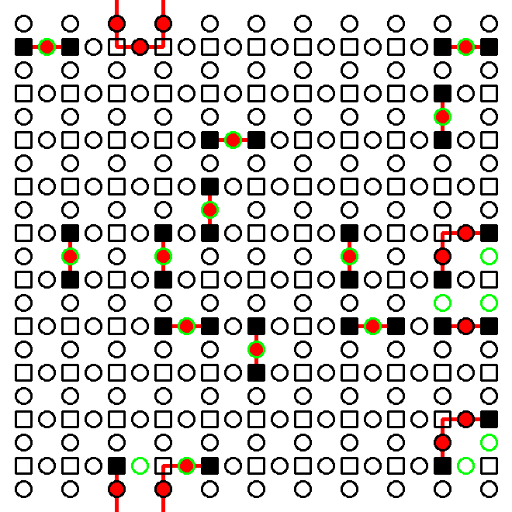

In [16]:
solution = x.evaluate(result.best.values).astype(int)  # 求めた解を元の変数に代入

show_sc_img(qubits, solution, stabilizers)

データ量子ビットの推定エラー位置を**緑色**の枠線で表しています。

推定エラー位置を反転することで、エラー訂正を行います。

訂正後のエラー状況を確認しましょう。

```^```は排他的論理和を計算する論理演算子であり、これによって推定エラー位置を反転させています。

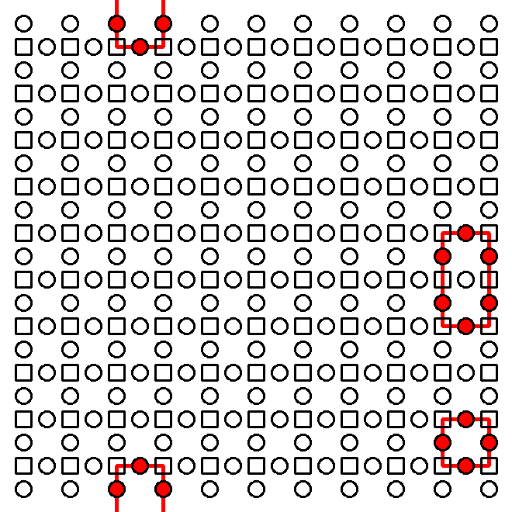

In [17]:
modified_qubits = qubits ^ solution  # エラー訂正後のエラー状況
modified_stabilizers = measure_stabilizers(
    modified_qubits
)  # エラー訂正後の補助量子ビットの測定結果

show_sc_img(modified_qubits, None, modified_stabilizers)

エラーが残っているデータ量子ビットは**赤色**、隣接するデータ量子ビットのエラー個数が奇数の補助量子ビットは**黒色**で表されています。

- 隣接するデータ量子ビットのエラー個数が奇数である補助量子ビットがない
- 一番上の行にあるデータ量子ビットのエラー個数が偶数

の 2 つの条件が満たされている場合、エラー訂正は成功です。

In [18]:
def check_success_or_failure(modified_qubits: np.ndarray, modified_stabilizers: np.ndarray) -> None:
    if modified_stabilizers.sum() != 0:
        print("復号失敗: 隣接するデータ量子ビットのエラー個数が奇数の補助量子ビットがあります")
    elif modified_qubits[0].sum() % 2 == 1:
        print("復号失敗: 一番上の行にあるデータ量子ビットのエラー個数が奇数です")
    else:
        print("復号成功です！")

check_success_or_failure(modified_qubits, modified_stabilizers)

復号成功です！


以下に、問題生成から最適化の結果確認までの処理を実行する関数を定義します。

In [19]:
# 一連の処理を実行する
def simulate(
    d: int,
    p: float,
    seed: int | None,
    timeout_ms: int
) -> None:
    # データ量子ビット格子を生成
    qubits = generate_qubit_lattice(d, p, seed)

    # 補助量子ビットでの測定結果
    stabilizers = measure_stabilizers(qubits)

    # 生成されたエラー状況を表示
    show_sc_img(qubits, None, stabilizers)

    # 組み合わせ最適化モデルを構築
    x, model = construct_model(d, stabilizers)

    # 最適化の実行
    result = solve_optimization(model, timeout_ms)

    # 推定エラー位置を表示
    solution = x.evaluate(result.best.values).astype(int)
    show_sc_img(qubits, solution, stabilizers)

    # 訂正後のエラー状況を表示
    modified_qubits = qubits ^ solution
    modified_stabilizers = measure_stabilizers(modified_qubits)
    show_sc_img(modified_qubits, None, modified_stabilizers)

    # 復号の成否を判定
    check_success_or_failure(modified_qubits, modified_stabilizers)

実行することで、ランダムに生成されたエラー状況、補助量子ビットでの測定結果から推定されたエラー位置、訂正（= 推定エラー位置の反転）後のエラー状況、復号の成否が縦に並んで表示されます。

格子のサイズやエラーの発生確率を変えて、エラー訂正の成功率を確認してみましょう。誤り訂正量子コンピュータの実現に Surface Code を用いた場合に、必要な量子ビット個数や要求されるエラー率について考察することもできます。

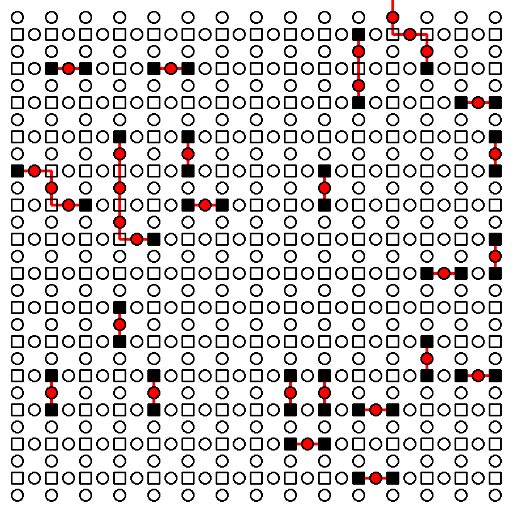

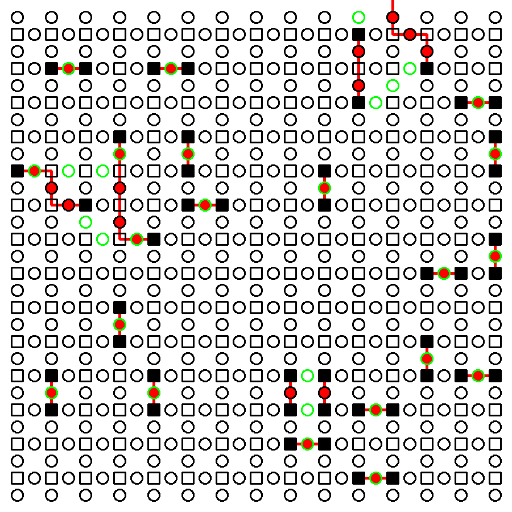

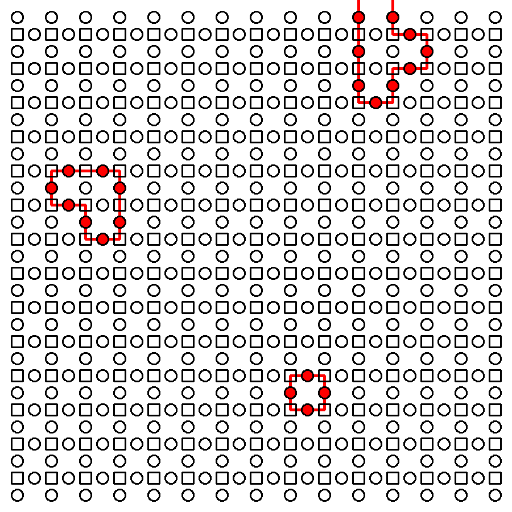

復号成功です！


In [20]:
d = 15  # 格子サイズ
p = 0.08  # エラー発生確率
seed = None  # 乱数のシード値 (整数を指定: 問題固定、None: ランダム生成)
timeout_ms = 3000  # 計算時間 (単位はミリ秒)
simulate(d, p, seed, timeout_ms)

<a id="proof"></a>
### 〈補足〉「どの補助量子ビット $j$ についても $S_j \le \bold{3}$ を満たす最適解が必ず存在する」ことの説明

任意に 1 つ取ってきた（$S_j=4$ の補助量子ビット $j$ が存在し得る）最適解から変形していくことで、すべての補助量子ビットについて $S_j \le \bold{3}$ を満たす最適解を構築することができます。

具体例として、以下の格子サイズ $d=5$ の量子ビット格子を用いて説明します。

![](../figures/surface_code_decoder/initial_solution.png)

☐ で表された補助量子ビットの測定結果が入力として与えられたとき、緑色の 〇 で示したデータ量子ビットの推定エラー状況は入力に対する最適解の 1 つです。

しかし、この最適解は $S_j=4$ を満たす（周囲の 4 つのデータ量子ビットがエラー位置と推定されている）補助量子ビットが存在します。

ここで、その補助量子ビットの右下にある 4 つのデータ量子ビットについて、推定エラー有無を反転させます。

![](../figures/surface_code_decoder/mark_flip.png)

$S_j=4$ を満たす補助量子ビットを青色、その右下にある 4 つのデータ量子ビットを赤色で示しました。

赤色のデータ量子ビットの推定エラー有無を反転させると以下のようになります。

![](../figures/surface_code_decoder/flipped.png)

この操作を行って得られた新しい解は補助量子ビットの測定結果に合致し、データ量子ビットの推定エラー個数は操作前より多くなることはありません。

よって、この解も入力に対する最適解の 1 つであり、また $S_j=4$ だった補助量子ビットは $S_j=2$ になっています。

上図のように、操作によって新たに $S_j=4$ を満たす補助量子ビットができることがありますが、これは必ず操作対象の補助量子ビットより 1 行下にできます。

したがって、上の行から掃き出すように $S_j=4$ を満たす補助量子ビットを消していくことで、すべての補助量子ビット $j$ について $S_j \le \bold{3}$ を満たす最適解が必ず得られます。

例の場合、最終的に以下の最適解が得られます。

![](../figures/surface_code_decoder/modified_solution.png)